*La base des TPs pour le cours "Classification des données" a été prise du cours en ligne "Open Machine Learning Course" (https://mlcourse.ai/, auteur Yury Kashnitsky)*



# <center> TP 2 : Les methodes de régression et classification

Dans ce TP, vous allez découvrir le fonctionnement d'un arbre de décision, aussi que de la méthode KNN etc., dans les tâches de régression et classification sur les données synthétiques et MNIST.

**Votre travail consiste à écrire du code et effectuer des calculs dans les cellules ci-dessous.**

Tout d'abord, nous allons initialiser l'environnement, importons tout les bibliothèques nécessaires

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
sns.set()

from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler

## 1. Arbres de décision et KNN methode pour la régression : données synthétiques

Considérons le problème de régression unidimensionnel suivant. Nous devons créer une fonction $\large a(x)$ pour approximer la dépendance $\large y = f(x) = x^3 $ en utilisant le critère d'erreur quadratique moyen: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

**Ex. 1** : Créez une fonction de génération des données (sur l'intervalle [-3,3]) avec le bruit normal de 40% pour ce problème. Vous pouvez utiliser la fonction [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) pour generer les données de l'axe x.

In [2]:
n_train = 100        
n_test = 100     
noise = 0.4

def generate(n_samples, noise):
  X = np.linspace(-3,3,n_samples)
  y = X ** 3 + np.random.normal(0.0, noise, n_samples) 
  X = X.reshape((n_samples, 1))
  
  return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

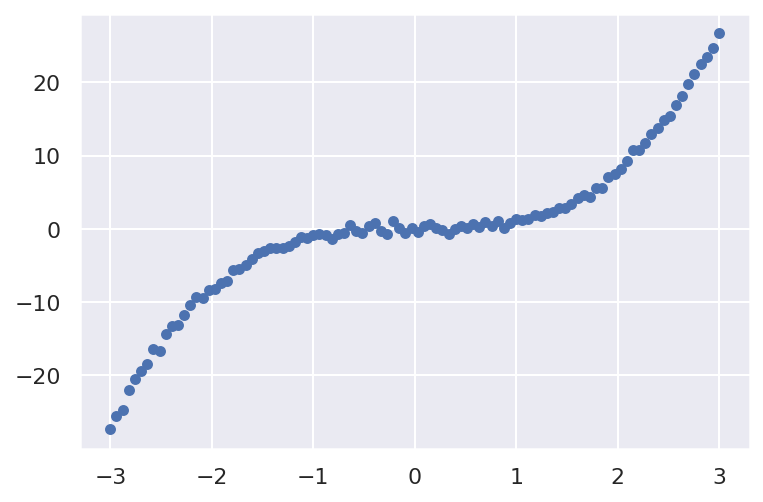

In [3]:
plt.scatter(X_train, y_train, c="b", s=20)
plt.show()

**Ex. 2** : Créez un arbre de decision, entraînez le sur données {X_train, y_train} et visualisez les prédictions qu’il réalise. Affichez votre l'erreur quadratique moyenne (MSE) obtenue sur les données de test {X_test, y_test}.


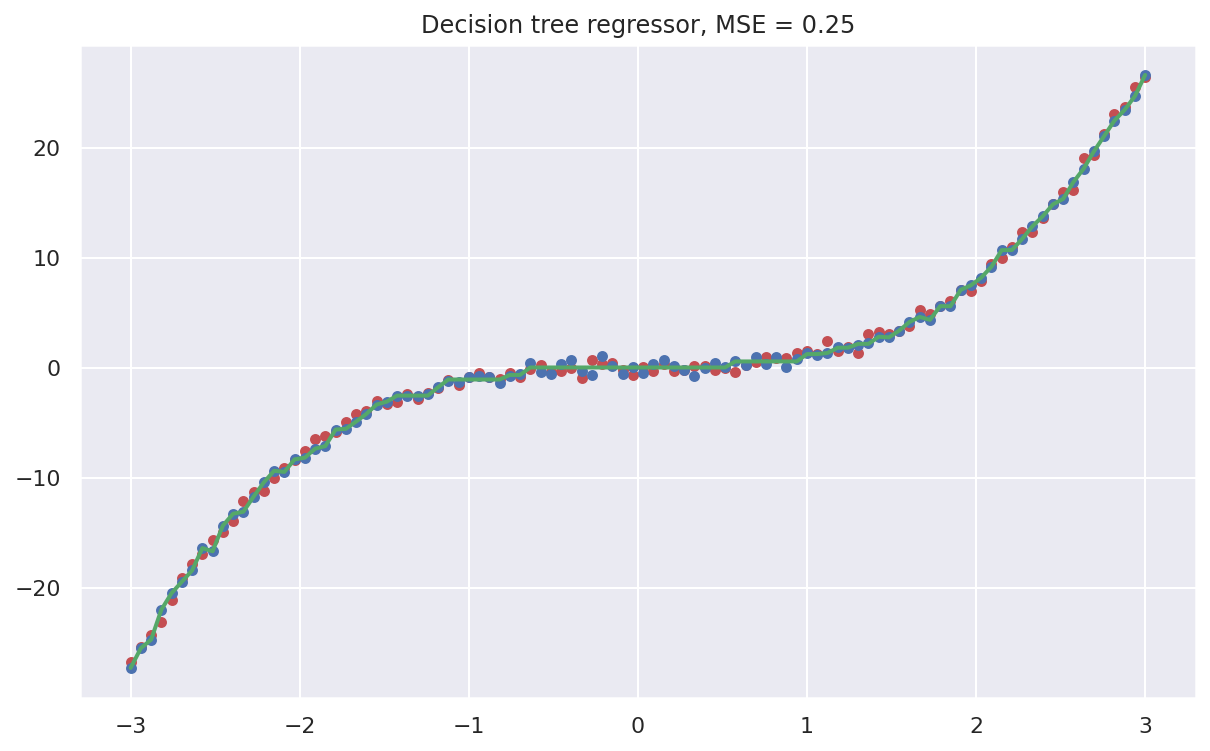

In [4]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=7, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

### Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, c="r", s=20)
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)

plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

**Ex. 3 (Bonus)** : Appliquez la méthode des plus proches voisins (KNN) à ce problème de régression, entraînez le sur données {X_train, y_train} et visualisez les prédictions qu’il réalise. Affichez votre l'erreur quadratique moyenne (MSE) obtenue sur les données de test {X_test, y_test}.

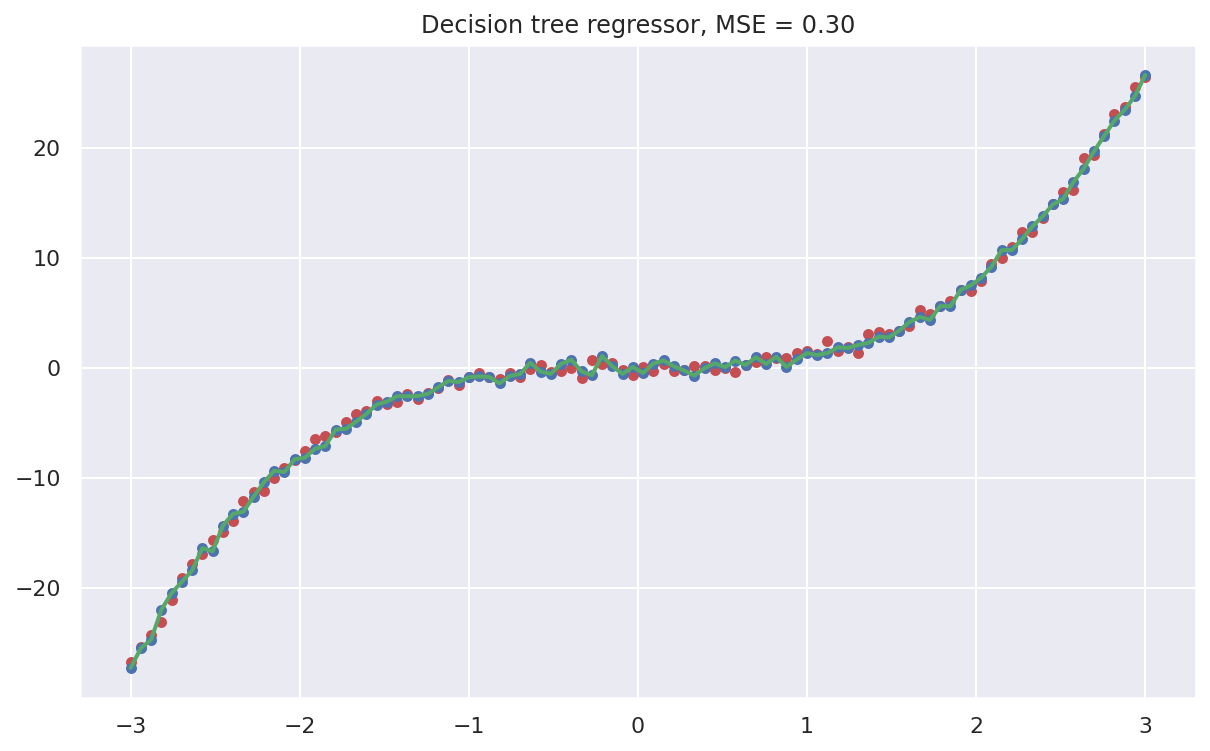

In [5]:
from sklearn.neighbors import KNeighborsRegressor

reg_knn = KNeighborsRegressor(n_neighbors=1)

reg_knn.fit(X_train, y_train)
reg_knn_pred = reg_knn.predict(X_test)

### Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, c="r", s=20)
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_knn_pred, "g", lw=2)

plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test - reg_knn_pred) ** 2) / n_test))
plt.show()

## 2. Arbres de décision, Forêts aléatoires and KNN methodes pour la classification : données synthétiques

Dans cette partie de TP vous allez appliquer les 3 classificateurs aux jeux de données synthétiques ci-dessous.

In [6]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_circles
random_state = 3

replace_zero = lambda x: -1 if x==0 else x

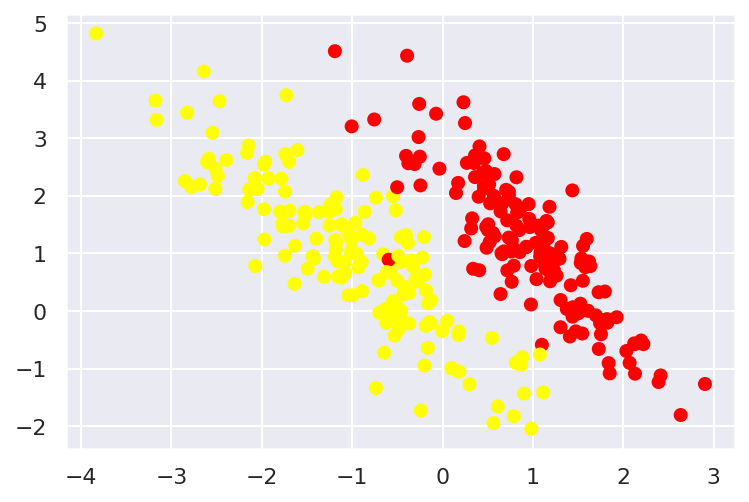

In [7]:
X1, y1 = make_classification(n_samples=300, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=random_state)
y1 = [replace_zero(x) for x in y1]
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='autumn')

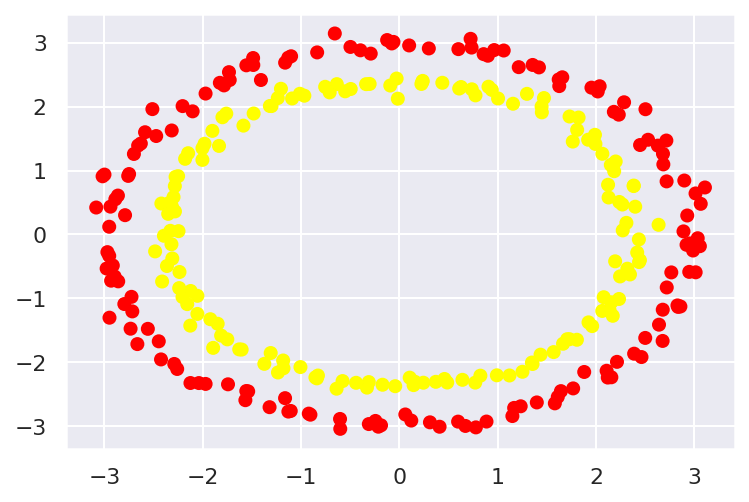

In [8]:
X2, y2 = make_circles(n_samples=300, noise=0.03, random_state=random_state)
X2 = 3*X2
y2 = [replace_zero(x) for x in y2]
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap='autumn')

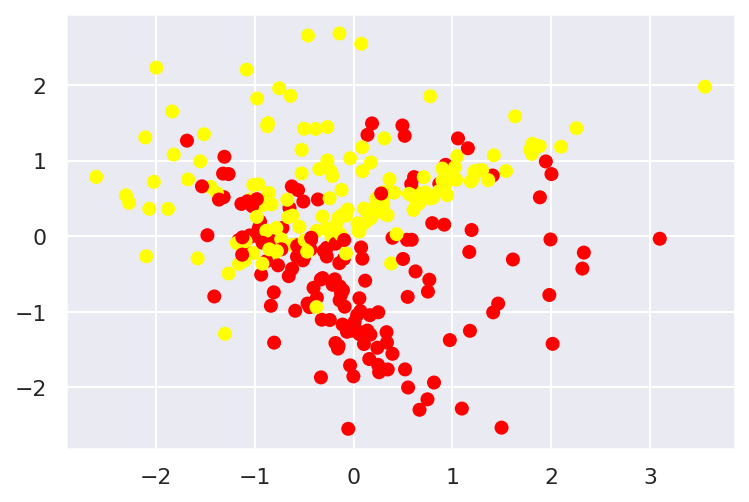

In [9]:
X3, y3 = make_classification(n_samples=300, n_features=2, n_redundant=0, n_clusters_per_class=2, hypercube=False, random_state=random_state)
y3 = [replace_zero(x) for x in y3]
plt.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='autumn')

**Ex. 4,5,6** : Séparez en deux classes les données {X1, y1}, {X2, y2} et {X3, y3} (respectivement) en entraînant des arbres de décision, Forêts aléatoires and KNN classificateurs via `sklearn`. Visualisez la limite de séparation résultante.  Affichez les matrices de confusion [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) et calculez les métriques de qualité de classification : Accuracy, Precision, Recall, F1 pour chaque classificateur (décrites dans les slides). Quelle méthode a la meilleure performance pour chaque exemple de données ?

In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def apply_metrics(algorithms_, data_, true_labels_, title='', 
                  algorithms_names=["Decision tree", "KNN"]):

  metrics = []
  for algo in algorithms_:
      labels = algo.predict(data_)
      metrics.append(({
          'Accuracy': accuracy_score(true_labels_, labels),
          'Precision': precision_score(true_labels_, labels),
          'Recall': recall_score(true_labels_, labels),
          'F1': f1_score(true_labels_, labels)
          }))

  results = pd.DataFrame(data=metrics, columns=['Accuracy','Precision',
                                                'Recall', 'F1'],
                         index=algorithms_names)
  
  return results

### Function to return the grid for resulting separation limit visualization (from TD2)
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))
    
def plot_copmarison(trained_algorithms_,data_train, labels_train, 
                    data_test=[], labels_test=[]):
  
  xx, yy = get_grid(data_train, eps=0.05)

  nb_of_algo = len(trained_algorithms_)
  fig, axs = plt.subplots(1, nb_of_algo, figsize=(10, 5))
  for i in range(nb_of_algo):
    algo = trained_algorithms_[i]
    predicted = algo.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axs[i].pcolormesh(xx, yy, predicted, cmap='autumn')
    axs[i].scatter(data_train[:, 0], data_train[:, 1], c=labels_train, s=100, 
                cmap='autumn', edgecolors='black', linewidth=1.5, 
                label='Train')
    if len(data_test)*len(labels_test):
      axs[i].scatter(data_test[:, 0], data_test[:, 1], c=labels_test, s=100, 
                  cmap='autumn', edgecolors='black', linewidth=5, label='Test')
      axs[i].legend()
  plt.show()

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

def my_classification(dataset, labels, max_tree_depth=7, n_neighbors=3):
  #data separation
  X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

  #models
  tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_tree_depth, random_state=17)
  tree.fit(X_train, y_train)

  knn = KNeighborsClassifier(n_neighbors=n_neighbors) 
  knn.fit(X_train, y_train)

  #prediction&metrics
  print('Metrics on training data : \n')
  print(apply_metrics([tree,knn], X_train, y_train))
  print(' \nMetrics on testing data : \n')
  print(apply_metrics([tree,knn], X_test, y_test))

  #visualisation
  plot_copmarison([tree,knn], X_train, y_train, X_test, y_test)

Metrics on training data : 

               Accuracy  Precision  Recall        F1
Decision tree  1.000000   1.000000     1.0  1.000000
KNN            0.991667   0.983051     1.0  0.991453
 
Metrics on testing data : 

               Accuracy  Precision    Recall        F1
Decision tree  0.966667   0.969697  0.969697  0.969697
KNN            1.000000   1.000000  1.000000  1.000000


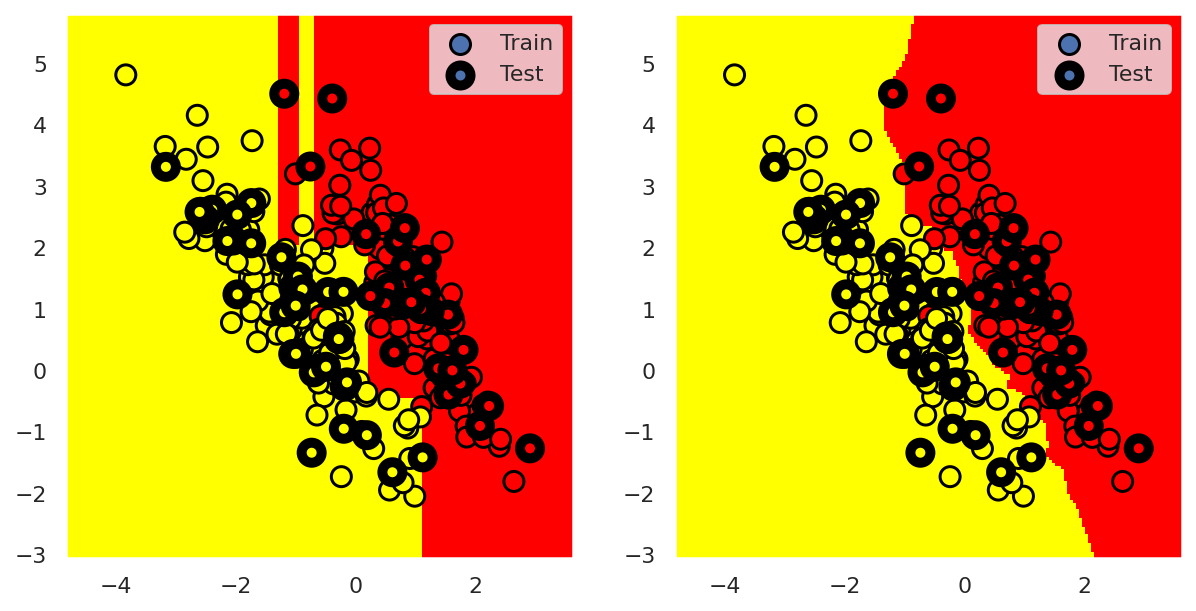

In [20]:
# Ex.4
my_classification(X1, y1)

Metrics on training data : 

               Accuracy  Precision  Recall       F1
Decision tree  0.966667   0.937008     1.0  0.96748
KNN            1.000000   1.000000     1.0  1.00000
 
Metrics on testing data : 

               Accuracy  Precision  Recall       F1
Decision tree  0.966667   0.939394     1.0  0.96875
KNN            1.000000   1.000000     1.0  1.00000


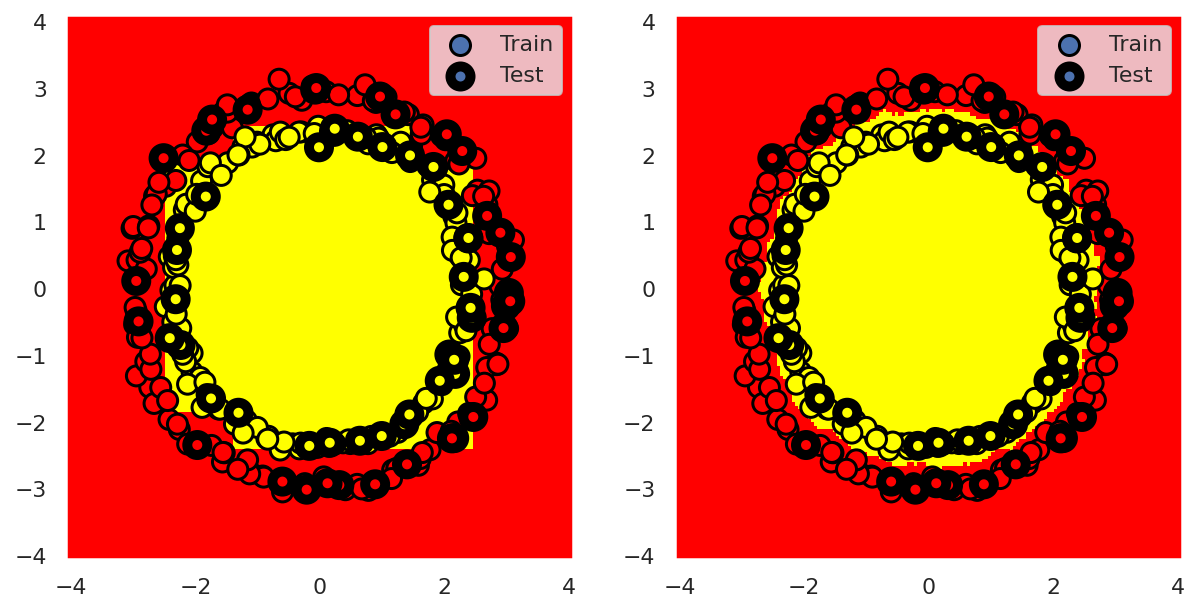

In [21]:
# Ex.5
my_classification(X2, y2)

Metrics on training data : 

               Accuracy  Precision    Recall        F1
Decision tree    0.9125   0.862319  0.983471  0.918919
KNN              0.9000   0.907563  0.892562  0.900000
 
Metrics on testing data : 

               Accuracy  Precision    Recall    F1
Decision tree  0.766667   0.750000  0.750000  0.75
KNN            0.766667   0.818182  0.642857  0.72


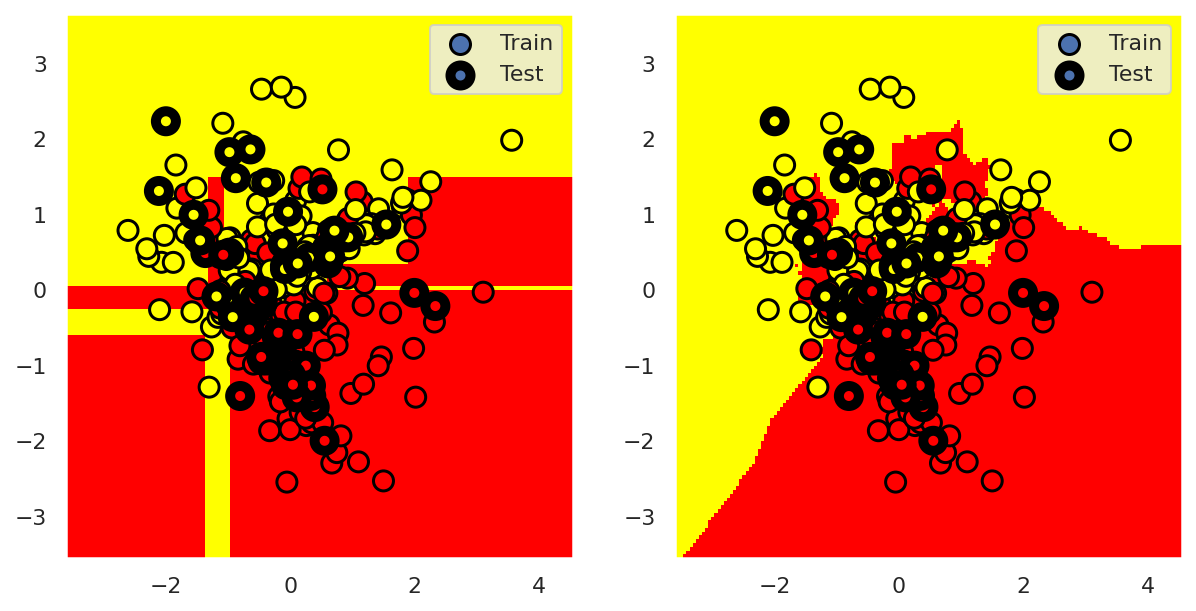

In [22]:
# Ex.6
my_classification(X3, y3)

## 3. Arbres de décision, k-NN et Forêt aléatoire dans une tâche de reconnaissance manuscrite de chiffres du MNIST

Voyons maintenant comment ces 3 algorithmes fonctionnent sur une tâche tirée du monde réel. Nous allons utiliser le jeu de données intégré dans `sklearn` sur des chiffres manuscrits. Cette tâche est un exemple où k-NN fonctionne étonnamment bien.
 
Les images sont des matrices 8x8 (intensité de la couleur blanche pour chaque pixel). Ensuite, chacune de ces matrices est "unfolded" (étalée, dépliée) en un vecteur de longueur 64 et nous obtenons une description des caractéristiques d'un objet.
 
Affichons quelques chiffres manuscrits. Nous voyons que l'on peut les distinguer.

In [ ]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0,:].reshape([8,8])

In [ ]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]), cmap='Greys');

**Ex. 7** : Séparez les données MNIST en *train* (70%) et *test* (30%) sous-ensemble des données 

In [ ]:
# You code here

**Ex. 8** : Appliquez les Arbres de décision, k-NN et Forêt aléatoire avec les paramètres aléatoires sur les données MNIST séparées. Affichez les résultats obtenus sur les données de *test*.

In [ ]:
# You code here

**Ex. 9** : Optimisez les paramètres des méthodes en utilisant la validation croisée (sur les données de *train*). Affichez les résultats obtenus sur les données de *test*.

In [ ]:
# You code here

**Ex. 10** : Organisez les résultats obtenus dans les ex.8-9 sous forme d'un tableau (lignes : DT, KNN, RF; colonnes : Holdout, CV).

In [ ]:
# You code here